## Stock Generator


In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path

In [2]:
# For clarity, I picked wise long-term investing approach, $29384710 to spend and 10 stocks to invest and
#   used my own file of list of tickers

# reads input for volatility
def safe_risky_wise ():
    standard = input('Please pick one from the three: "safe", "risky" or "wise" stocks')
    if (standard != 'safe') & (standard != 'risky') & (standard != 'wise'):
        print ("Input invalid please try again")
        return safe_risky_wise ()
    else:
        return standard

# reads input for duration
def short_long ():
    term = input('Please pick one from the two: "short" or "long" term')
    if (term !='short') & (term !='long'):
        print ("Input invalid please try again")
        return short_long ()
    else:
        return term

# reads input for number of stocks
def pick_num ():
    wish_to_pick = input('Please enter the number of stocks desired to pick')
    if (not (wish_to_pick.isnumeric())) | int(wish_to_pick) <= 0:
        print ("Input invalid please try again")
        return pick_num()
    else:
        return wish_to_pick

# reads input for amount of money
def money ():
    money = input('Please enter the amount of money to invest')
    if (not money.isnumeric()) | int(money) <= 0:
        print ("Input invalid please try again")
        return pick_num()
    else:
        return money
    
# reads input for ticker file provided
def pick_file ():
    user_input = input("Please upload your csv ticker file name")
    file_name = Path(user_input)
    if file_name.exists():
        return user_input
    else:
        print("File not found please try again")
        return pick_file()

# execute reading inputs
volatility = safe_risky_wise()
short_long = short_long()
money = int(money())
wish_to_pick = pick_num()
file = pick_file()

Please pick one from the three: "safe", "risky" or "wise" stocks wise
Please pick one from the two: "short" or "long" term long
Please enter the amount of money to invest 29384710
Please enter the number of stocks desired to pick 10
Please upload your csv ticker file name Tickers.csv


In [3]:
# read CSV file
ticker_df = pd.read_csv(file, header = None)
ticker_df.columns = ['Tickers']
unfiltered_ticker_lst = list(ticker_df['Tickers'])

# create lists 
ticker_list = []
ticker_dict ={}
ticker_history = {}
ticker_info = {}

# timeframe
start_date = '2020-01-01'
purchase_date = datetime.date(datetime.now()) # day of purchase.

# extract ticker info and ticker history
for name in unfiltered_ticker_lst:
    ticker_info[name] = yf.Ticker(name).info
    if ticker_info[name].get('regularMarketPrice') == None:
        continue
    else:
        ticker_history[name] = yf.Ticker(name).history (start = start_date, end = purchase_date, interval = '1d')
    
# filter stocks
for i in unfiltered_ticker_lst:
    info = ticker_info[i]
    # filter out invalid tickers
    if info.get('regularMarketPrice') == None:
        continue
        
    # filter out tickers that are not denominated in USD
    if info.get('currency')!= 'USD':
        continue
    if info.get ('market') != ('us_market'):
        continue
    history = ticker_history[name]
    
    # filter out tickers that are not actively trading
    if history.Volume.mean() < 10000:
        continue
    else:
        ticker_list.append(i)
        ticker_dict[i] = info
        
# remove the duplicated tickers
ticker_list = list(dict.fromkeys(ticker_list))

In [4]:
# calculate market capitalization
# getting number of shares outstanding for each valid ticker
share_list = []
for name in ticker_list:
    share_list.append(ticker_info[name].get('sharesOutstanding'))

# create dataframe for market capitalisation
df_market_cap = pd.DataFrame({'company' :ticker_list})
df_market_cap['outstanding_shares'] = share_list
df_market_cap['closing'] = 0

# function that returns the most recent available closing price (closest to end-date)
def find_closing (df_close, i):
    closing = df_close.Close.iloc[i]
    if pd.isna(closing) == True:
        return find_closing (df_close, i-1)
    else:
        return closing

# read in all the tickers and extract the outstanding shares and closing prices
i=0
pd.options.mode.chained_assignment = None

for ticker in ticker_list:
    df_market_cap.closing.iloc[i] = find_closing(ticker_history[ticker], -3);
    i+=1;

# calculate the market capitalisation
df_market_cap['Market_Cap'] = df_market_cap.closing* df_market_cap.outstanding_shares

# rank the stocks based on their market cap
# higher market cap would have higher rank (higher number)
# tickers that don't have outstanding shares information available on yf finance
#   would automatically be assigned the mean rank
df_market_cap['Rank'] = df_market_cap.Market_Cap.rank(method='max')
df_market_cap['Rank'] = df_market_cap['Rank'].fillna(df_market_cap['Rank'].mean())
market_cap_dict = dict(zip (ticker_list, df_market_cap['Rank'].to_list()))

In [5]:
df_market_cap

,company,outstanding_shares,closing,Market_Cap,Rank
0,AAPL,16406400000,175.529999,2.879815e+12,25.0
1,ABBV,1767879936,135.879990,2.402195e+11,18.0
2,LOW,673747008,250.720001,1.689219e+11,12.0
3,AMZN,507148000,3304.139893,1.675688e+12,24.0
4,AXP,774556032,174.470001,1.351368e+11,10.0
5,BAC,8184079872,48.860001,3.998741e+11,21.0
6,BK,825820992,63.549999,5.248092e+10,3.0
7,SQ,399175008,145.470001,5.806799e+10,5.0
8,VZ,4197760000,53.450001,2.243703e+11,14.0
9,CMCSA,4559479808,50.950001,2.323055e+11,15.0


In [6]:
##Get the beta of the stock
ticker_beta = {}
for k in ticker_list:
    if ticker_dict[k]['beta'] == None:
        ticker_beta[k] = 1
    else:
        ticker_beta[k] = ticker_dict[k]['beta']
        
# rank the companies based on beta
ticker_beta_rank = {key: rank for rank, key in enumerate(sorted(ticker_beta, key=ticker_beta.get, reverse=True), 1)}

# show beta dataframe
ticker_beta_df = pd.DataFrame(ticker_beta.items(), columns = ['Ticker', 'Beta'])
ticker_beta_df.set_index('Ticker', inplace = True)
ticker_beta_df['Rank'] = ticker_beta_df.Beta.rank(method = 'max', ascending = False)
ticker_beta_df

,Beta,Rank
Ticker,,
AAPL,1.203116,9.0
ABBV,0.788051,21.0
LOW,1.294025,7.0
AMZN,1.126233,13.0
AXP,1.238961,8.0
BAC,1.508571,5.0
BK,1.148571,12.0
SQ,2.381818,2.0
VZ,0.411948,25.0


In [7]:
##Get the return and standard deviation of each stock to calculate risk adjusted daily returns 
tickers_close = []
tickers_close_dict = {}

# extract closing prices and arrange them
for i in ticker_list:
    tickers_close.append(ticker_history[i]['Close'])
    close = ticker_history[i]['Close']
    tickers_close_dict[i] = close
    
ticker_keys = tickers_close_dict.keys()
listof_rate_of_return = []
listof_std = []

# using closing prices to calculate expected rate of return and standard deviation
for i in range(len(tickers_close)):
    close_df = pd.DataFrame(tickers_close[i])
    pct_change = 100*close_df.pct_change()
    pct_change.columns = ['Rate of Return (%)']
    avg_pct_change = pct_change['Rate of Return (%)'].describe()['mean']
    listof_rate_of_return.append(avg_pct_change)
    std = pct_change.std()
    listof_std.append(std)
listof_std_float = []

# return dictionaries
for i in range(len(listof_std)):
    listof_std_float.append(float(listof_std[i]))
rate_of_return_dict_1d = dict(zip(ticker_keys, listof_rate_of_return))
std_dict_1d = dict(zip(ticker_keys, listof_std_float))

 # calculate the sharp ratio
return_over_std_1d_dict={}
for ticker in ticker_list:
    ratio = (rate_of_return_dict_1d[ticker]/std_dict_1d[ticker])
    return_over_std_1d_dict[ticker] = ratio

# sort and rank the tickers based on three criterias respectively
return_over_std_rank_1d = {key: rank for rank, key in enumerate(sorted(return_over_std_1d_dict, key = return_over_std_1d_dict.get, reverse = False), 1)}
rate_of_return_dict_1d = {key: rank for rank, key in enumerate(sorted(rate_of_return_dict_1d, key = rate_of_return_dict_1d.get, reverse = True), 1)}
std_dict_1d = {key: rank for rank, key in enumerate(sorted(std_dict_1d, key = std_dict_1d.get, reverse = True), 1)}

# produce dataframe for daily data
daily_df = pd.DataFrame(ticker_list, columns = ['Ticker'])
daily_df['Std'] = listof_std_float
daily_df['StdRank'] = daily_df.Std.rank(method = 'max', ascending = False)
daily_df['ExpectedReturn'] = listof_rate_of_return
daily_df['ExpectedReturnRank'] = daily_df.ExpectedReturn.rank(method = 'max', ascending = False)
daily_df['SharpRatio'] = daily_df.ExpectedReturn / daily_df.Std
daily_df['SharpRatioRank'] = daily_df.SharpRatio.rank(method = 'max')
daily_df

,Ticker,Std,StdRank,ExpectedReturn,ExpectedReturnRank,SharpRatio,SharpRatioRank
0,AAPL,2.348064,13.0,0.192410,3.0,0.081944,25.0
1,ABBV,1.780873,22.0,0.118700,13.0,0.066653,20.0
2,LOW,2.491114,11.0,0.175332,4.0,0.070383,21.0
3,AMZN,2.016894,18.0,0.124527,12.0,0.061742,19.0
4,AXP,3.098051,7.0,0.109069,14.0,0.035206,10.0
5,BAC,2.837398,9.0,0.106460,15.0,0.037520,11.0
6,BK,2.439834,12.0,0.084529,17.0,0.034645,9.0
7,SQ,3.971895,3.0,0.223460,2.0,0.056260,17.0
8,VZ,1.261954,25.0,0.000695,25.0,0.000551,1.0
9,CMCSA,2.004655,19.0,0.052289,23.0,0.026084,5.0


In [8]:
# Get the return and standard deviation of each stock to calculate risk adjusted monthly returns 
tickers_close_1mo = []
tickers_close_dict_1mo = {}

# Get monthly data from yf finance and extract closing prices
for i in ticker_list:
    tickers_close_1mo.append(yf.Ticker(i).history(start="2019-01-01", end=purchase_date, interval='1mo')['Close'])
    close_1mo = yf.Ticker(i).history(start="2019-01-01", end="2021-11-01", interval='1mo')['Close']
    tickers_close_dict_1mo[i] = close_1mo

ticker_keys = tickers_close_dict_1mo.keys()
listof_rate_of_return_1mo = []
listof_std_1mo = []

# use closing prices to calculate expect monthly return and standard deviation
for i in range(len(tickers_close_1mo)):
    close_df_1mo = pd.DataFrame(tickers_close_1mo[i])
    pct_change_1mo = 100*close_df_1mo.pct_change()
    pct_change_1mo.columns = ['Rate of Return (%)']
    avg_pct_change_1mo = pct_change_1mo['Rate of Return (%)'].describe()['mean']
    listof_rate_of_return_1mo.append(avg_pct_change_1mo)
    std_1mo = pct_change_1mo.std()
    listof_std_1mo.append(std_1mo)
listof_std_1mo_float = []

# return dictionaries
for i in range(len(listof_std_1mo)):
    listof_std_1mo_float.append(float(listof_std_1mo[i]))
    
rate_of_return_dict_1mo = dict(zip(ticker_keys, listof_rate_of_return_1mo))
std_dict_1mo = dict(zip(ticker_keys, listof_std_1mo_float))

# calculate sharp ratio
return_over_std_1mo_dict={}
for ticker in ticker_list:
    ratio = (rate_of_return_dict_1mo[ticker] / std_dict_1mo[ticker])
    return_over_std_1mo_dict[ticker] = ratio

# rank the tickers by the three criterias respectively and return a dict
return_over_std_rank_1mo = {key: rank for rank, key in enumerate(sorted(return_over_std_1mo_dict, key = return_over_std_1mo_dict.get, reverse = False), 1)}
rate_of_return_dict_1mo = {key: rank for rank, key in enumerate(sorted(rate_of_return_dict_1mo, key = rate_of_return_dict_1mo.get, reverse = True), 1)}
std_dict_1mo = {key: rank for rank, key in enumerate(sorted(std_dict_1mo, key = std_dict_1mo.get, reverse = True), 1)}

# produce dataframe for monthly data
monthly_df = pd.DataFrame(ticker_list, columns = ['Ticker'])
monthly_df['Std'] = listof_std_1mo_float
monthly_df['StdRank'] = monthly_df.Std.rank(method = 'max', ascending = False)
monthly_df['ExpectedReturn'] = listof_rate_of_return_1mo
monthly_df['ExpectedReturnRank'] = monthly_df.ExpectedReturn.rank(method = 'max', ascending = False)
monthly_df['SharpRatio'] = monthly_df.ExpectedReturn / monthly_df.Std
monthly_df['SharpRatioRank'] = monthly_df.SharpRatio.rank(method = 'max')
monthly_df

,Ticker,Std,StdRank,ExpectedReturn,ExpectedReturnRank,SharpRatio,SharpRatioRank
0,AAPL,8.091489,11.0,3.837404,2.0,0.474252,25.0
1,ABBV,7.387269,16.0,1.955913,9.0,0.264768,17.0
2,LOW,8.559186,9.0,2.768008,4.0,0.323396,21.0
3,AMZN,7.397687,15.0,1.980473,8.0,0.267715,18.0
4,AXP,8.329369,10.0,1.730279,13.0,0.207732,11.0
5,BAC,8.811811,8.0,1.872860,11.0,0.212540,12.0
6,BK,7.537315,12.0,0.978195,23.0,0.129780,6.0
7,SQ,16.128062,2.0,2.995846,3.0,0.185754,9.0
8,VZ,3.623897,25.0,0.327042,25.0,0.090246,4.0
9,CMCSA,6.040065,20.0,1.171901,19.0,0.194021,10.0


In [9]:
#creating a dictionary with each stock ranking 
stock_wise_short = {}
stock_score_short = {}
stock_score_long = {}
stock_wise_long = {}

# assign total scores for each stock based on their rank for each measuring metrics
for ticker in ticker_list:
    # wise
    score = 0.2 * (ticker_beta_rank[ticker]) + 0.4 * (return_over_std_rank_1d[ticker]) + 0.1 * market_cap_dict[ticker] + 0.15 * (std_dict_1d[ticker]) + 0.15 * (rate_of_return_dict_1d[ticker])
    wise_long = 0.2 * (ticker_beta_rank[ticker]) + 0.4 * (return_over_std_rank_1mo[ticker]) + 0.1 * market_cap_dict[ticker] + 0.15 * (std_dict_1mo[ticker]) + 0.15 * (rate_of_return_dict_1d[ticker])
    
    # safe/ risky
    score_short = 0.3 * (ticker_beta_rank[ticker]) + 0.35 * (std_dict_1d[ticker]) + 0.35 * (rate_of_return_dict_1d[ticker])
    score_long = 0.3 * (ticker_beta_rank[ticker]) + 0.35 * (std_dict_1mo[ticker]) + 0.35 * (rate_of_return_dict_1d[ticker])
    
    # return dict
    stock_wise_short[ticker] = {ticker:score}
    stock_wise_long[ticker] = {ticker:wise_long}
    stock_score_short[ticker] = score_short
    stock_score_long[ticker] = score_long

# sort the dicts for non-wise choices
stock_score_long = dict(sorted(stock_score_long.items(), key=lambda item: item[1]))
stock_score_short = dict(sorted(stock_score_short.items(), key=lambda item: item[1]))

In [10]:
# sorting the stocks into their respective sector, 
# so portfolio is built with differen sectors to minimize concentration and add diversification
wise_short = {}
wise_long= {}

# function to filter stocks based on their sector
def filter_sector (score_list,ticker_sector):
    for ticker in ticker_list:
        if 'sector' not in ticker_dict[ticker].keys():
            if 'other' not in ticker_sector:
                ticker_sector['other'] = score_list[ticker]
            else:
                ticker_sector['other'].update(score_list[ticker])
        else:
            sector = ticker_dict[ticker]['sector']
            if sector not in ticker_sector:
                ticker_sector[sector] = score_list[ticker]
            else:
                ticker_sector[sector].update(score_list[ticker])
    for sector in ticker_sector:
        ticker_sector[sector] = sorted(ticker_sector[sector].items(), key= lambda x: x[1], reverse=True)
    return ticker_sector

# filter stocks based on sectors for wise investing
wise_short = filter_sector(stock_wise_short, wise_short)
wise_long = filter_sector(stock_wise_long, wise_long)

In [11]:
# decided the number of tickers based on user's choice
company_num = len(ticker_list)
wish_to_pick = int(wish_to_pick)
if wish_to_pick > company_num:
    print("Exceeds the limit (number entered more than the provided file)")
company_num = wish_to_pick

# pick the tickers
wise_short_picked = []
wise_long_picked = []


# function that picks the tickers
def pick_stock (num, ticker_sector, picked_ticker_list):
    for sector in ticker_sector:
        if (company_num == num):
            return picked_ticker_list
        elif (len(ticker_sector[sector]) == 0):
            continue
        else:
            picked_ticker_list.append (list(ticker_sector[sector])[0])
            ticker_sector[sector].pop(0)
            num += 1
            continue
    if company_num > num:
        return pick_stock (num, ticker_sector, picked_ticker_list)
    if company_num == num:
        return picked_ticker_list
    return picked_ticker_list
  
# perform the function to filter ticker list and pick the stocks (amount decided by users)
wise_short_picked = dict(pick_stock(0, wise_short, wise_short_picked))
wise_long_picked = dict(pick_stock(0, wise_long, wise_long_picked))


In [12]:
# Based on user's choices of volatility and duration, generate the best stocks that meet their needs
final_list = []
final_dict = {}

if volatility == 'safe':
    if short_long == 'short':
        final_list = stock_score_short.keys[:wish_to_pick]
        final_dict = stock_score_short
    elif short_long == 'long':
        final_list = stock_score_long.keys[:wish_to_pick]
        final_dict = stock_score_long

elif volatility == 'risky':
    if short_long == 'short':
        final_list = stock_score_short.keys[-wish_to_pick:]
    elif short_long =='long':
        final_list = stock_score_long.keys[-wish_to_pick:]
        
elif volatility == 'wise':
    if short_long == 'long':
        final_list = wise_long_picked.keys()
        final_dict = wise_long_picked
    elif short_long == 'short':
        final_list = wise_short_picked.keys()
        final_dict = wise_short_picked

In [13]:
# assign weights proportional to their total score
total_score = 0
stock_weight = {}

for stock in final_list:
    total_score += final_dict[stock]

for stock in final_list:
    stock_weight[stock] = final_dict[stock]/total_score

# extract the closing price on purchase date
ticker_closing_list = []
for ticker in final_list:
    ticker_closing_list.append(ticker_history[ticker].Close.iloc[-1])

##column names and values for weights and tickers
weight_list = list(stock_weight.values())

In [14]:
# create final portfolio dataframe
FinalPortfolio = pd.DataFrame({'Ticker': final_list,  'Weight' : weight_list, 'Price' : ticker_closing_list})
FinalPortfolio['Shares'] = (FinalPortfolio.Weight * money)/ FinalPortfolio.Price
FinalPortfolio['Value'] = FinalPortfolio.Weight * money
FinalPortfolio = FinalPortfolio.drop(columns='Weight')
FinalPortfolio['Weight'] = weight_list 
FinalPortfolio['Weight'] = FinalPortfolio['Weight'] * 100 

# make index start from 1
FinalPortfolio.index += 1

print ("The total value adds up to", round(FinalPortfolio['Value'].sum(), 3), "and the total weight adds up to", round(FinalPortfolio['Weight'].sum(), 3))

The total value adds up to 29384710.0 and the total weight adds up to 100.0


In [15]:
FinalPortfolio

,Ticker,Price,Shares,Value,Weight
1,ORCL,87.690002,41383.883408,3.628953e+06,12.349800
2,ABBV,135.869995,24759.972626,3.364137e+06,11.448598
3,AMZN,3242.760010,982.987856,3.187594e+06,10.847797
4,JPM,157.889999,19194.794032,3.030666e+06,10.313752
5,GOOG,2795.729980,1245.411092,3.481833e+06,11.849132
6,COST,502.989990,8092.232539,4.070312e+06,13.851802
7,SLB,37.810001,26199.577063,9.906060e+05,3.371162
8,SO,68.660004,51425.471051,3.530873e+06,12.016021
9,SPG,155.699997,5669.353083,8.827183e+05,3.004005
10,AAPL,173.070007,18587.955822,3.217018e+06,10.947931


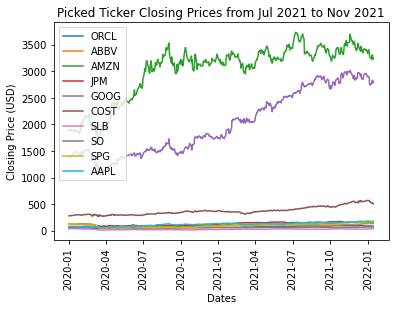

In [16]:
# graph the closing prices for each company picked to show their trends
for ticker in final_list:
    plt.plot(ticker_history[ticker].index, ticker_history[ticker].Close, label=ticker)

# labels
plt.title('Picked Ticker Closing Prices from Jul 2021 to Nov 2021')
plt.xlabel('Dates')
plt.xticks(rotation=90)
plt.ylabel('Closing Price (USD)')


# Create legend
plt.legend(loc='best')

plt.show()

In [17]:
# returns only the tickers and amount of shares recommended for users
Stocks = FinalPortfolio [['Ticker', 'Shares']]
Stocks

,Ticker,Shares
1,ORCL,41383.883408
2,ABBV,24759.972626
3,AMZN,982.987856
4,JPM,19194.794032
5,GOOG,1245.411092
6,COST,8092.232539
7,SLB,26199.577063
8,SO,51425.471051
9,SPG,5669.353083
10,AAPL,18587.955822
